In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import os
import scipy.signal
from scipy.signal import butter, lfilter, savgol_filter, find_peaks
from scipy.optimize import curve_fit
from itertools import chain, zip_longest

In [2]:
class AnalysePSData:
    """ Input is noisy data from Pico-Scope. Output is (x, y) coordinate pairs of local maxima and minima. 
        Works by filtering the input signal, and then applying a standard max / min filter."""
    # fit spline to smooth signal
    
    def __init__(self, fp):
        self._ps_data = scipy.io.loadmat(fp)  # ps data as dictionary
        self.signal_raw = self._ps_data['A'][0] # A is photo-diode channel
        self.signal_sawtooth = self._ps_data['C'][0]  # C is voltage channel on pico-scope
        self.signal_flp = np.array([0.]) # low-pass filter
        self.signal_savgol = np.array([0.]) # savitzky goyal filter
        self.signal_localreg = np.array([0.]) # piecewise local regression
        self.signal_to_analyse = np.array([0.])  # signal that represents one sawtooth upwards turn
        self.signal_cos_fit = np.array([0.])
        self.f_cut_lp = 0 # low-pass cut frequency
        self.dT = self._ps_data['Tinterval'][0][0] # indices s.t. self.dT is an integer
        self.fs = 1 / self.dT # sampling rate in 1/s
        self.N = self.signal_raw.size
        self.t0 = self._ps_data['Tstart'][0][0]
        self.t1 = self.t0 + self.dT + self.N
        self.t = np.linspace(self.t0, self.t1, self.N)
        self.idx_wn = [np.argmin(self.signal_sawtooth), np.argmax(self.signal_sawtooth)] # indices that indicate start / end of sawtooth
        self.idx_loc_extr = np.array([0])
        self.idx_max, self.idx_min = np.array([0]), np.array([0])
        self.signal_sg_split, self.signal_voltage_split = {}, {}
        self.signal_sawtooth_split, self.voltage_ordered = {}, {}
        self.t_split, self.signal_raw_split = {}, {}
        self.p_opt = {}
        assert self.t.size == self.signal_raw.size
        
    def get_sawtooth_local_extrema(self):
        """ Get local extrema of sawtooth function. Use min. height 0.95 percent of maximum value. Min. distance for N peaks should be
         larger than array.size // N """
        distance = self.signal_sawtooth.size // 10  # we expect five peaks
        height_min = np.amax(self.signal_sawtooth) * 0.95
        idx_max, _ = find_peaks(self.signal_sawtooth, distance=distance, height=height_min)
        signal_inv = np.amax(self.signal_sawtooth) - self.signal_sawtooth
        height_min = np.amax(signal_inv) * 0.95
        idx_min, _ = find_peaks(signal_inv, distance=distance, height=height_min)
        # interleave both lists - copied from Stack-Overflow
        if idx_max[0] < idx_min[0]: # max is first
            l1, l2 = idx_max, idx_min
        else:
            l1, l2 = idx_min, idx_max
        self.idx_loc_extr = np.array([x for x in chain(*zip_longest(l1, l2)) if x is not None], dtype=idx_max.dtype) 
        
    def fit_sinusoid(self, t1, w0=3.5e-3, phase0=0, verbose=False):
        """ Fits sinusoid w. frequency w0 to the first fringe of self.signal_to_analyse"""
        assert isinstance(self.signal_to_analyse, np.ndarray)
        def f(x, ac, dc, w, phase):
            return ac * np.cos(w * x + phase) + dc
        ydata = self.signal_to_analyse[:t1]
        xdata = np.arange(ydata.size)
        ac0 = (np.amax(self.signal_to_analyse) - np.amin(self.signal_to_analyse)) / 2
        dc0 = (np.amax(self.signal_to_analyse) + np.amin(self.signal_to_analyse)) * 0.5
        
        popt, _ = curve_fit(f, xdata, ydata, p0=[ac0, dc0, w0, phase0])
        self.p_opt.update({"ac0": ac0, "dc0": dc0, "w0": w0, "phase0": phase0})
        if verbose:
            print(popt[-2:])
        t_all = np.arange(self.signal_to_analyse.size)
        self.signal_cos_fit = f(t_all, *popt)
        
    def filter_lowpass(self, cutoff_pc=0.01, order=6):
        """ Implement low-pass filter. cutoff_pc is the frequency (as percentage of sampling rate) at which signal is db3 attenuated.
            Partially copied."""
        self.f_cut_lp = cutoff_pc * self.fs  # desired cutoff frequency of the filter, Hz
        # Get the filter coefficients so we can check its frequency response.
        b, a = butter(order, self.f_cut_lp, fs=self.fs, btype='low', analog=False)
        self.signal_flp = lfilter(b, a, self.signal_raw)

    def filter_savgol(self, polyorder=2):
        """ apply savitzky golay filter"""
        window_length = self.N // 100
        self.signal_savgol = savgol_filter(self.signal_raw, window_length, polyorder)

        
    def split_signal_sg(self, buffer=0, flip=False):
        """ Splits sg-filtered signal into chunks marked by min. max. of sawtooth voltage."""
        if self.signal_sawtooth.size < 10:
            raise ValueError("Filter signal first")
        # If we have N max. and M min. we get N + M - 1 chunks
        num_chunks = self.idx_loc_extr.size - 1
        for i in range(num_chunks):  # not efficient but works for now
            sg = self.signal_savgol[self.idx_loc_extr[i]+buffer:self.idx_loc_extr[i + 1]-buffer]
            tt = self.t[self.idx_loc_extr[i]+buffer:self.idx_loc_extr[i + 1]-buffer]
            sr = self.signal_raw[self.idx_loc_extr[i]+buffer:self.idx_loc_extr[i + 1]-buffer]
            ss = self.signal_sawtooth[self.idx_loc_extr[i]+buffer:self.idx_loc_extr[i + 1]-buffer]
            idx_array = np.argsort(ss) # re-order signal as a function of voltage
            sv = np.array(sr)[idx_array] # signal sorted as a function of voltage
            vv = np.array(ss)[idx_array] # voltages re-ordered
            
            if flip and (i % 2 == 0): # flip every 2nd chunk
                sg = np.flip(sg)
                tt = np.flip(tt)
                sr = np.flip(sr)
                ss = np.flip(ss)
            self.signal_sg_split[str(i)] = sg.tolist()
            self.t_split[str(i)] = tt.tolist()
            self.signal_raw_split[str(i)] = sr.tolist()
            self.signal_sawtooth_split[str(i)] = ss.tolist()
            self.signal_voltage_split[str(i)] = sv.tolist()
            self.voltage_ordered[str(i)] = vv.tolist()
    
    @staticmethod
    def get_idx_local_extrema(signal_to_analyze, distance, buffer=None):
        """ Uses Savitzky Golay filtered signal in window set by sawtooth function. Works only for one sawtooth upturn."""
        height_min = np.amax(signal_to_analyze) * 0.8
        
        idx_max_lbd1, _ = find_peaks(signal_to_analyze, distance=distance, height=height_min)
        signal_inv = np.amax(signal_to_analyze) - signal_to_analyze
        height_min = np.amax(signal_inv) * 0.8
        idx_min_lbd1, _ = find_peaks(signal_inv, distance=distance, height=height_min)
            
        if idx_max_lbd1[0] < idx_min_lbd1[0]: # max is first
            l1, l2 = idx_max_lbd1, idx_min_lbd1
        else:
            l1, l2 = idx_min_lbd1, idx_max_lbd1
        idx_minmax = np.array([x for x in chain(*zip_longest(l1, l2)) if x is not None], dtype=np.int64)
        
        return idx_minmax
            
    def get_fringe_distances(self):
        """ verify that time indices are correct before visually"""
        diff_max = np.diff(self.idx_max, axis=0)
        diff_min = np.diff(self.idx_min, axis=0)
        
        return diff_max, diff_min
        

class PostProcess():
    """ Takes two filtered signals, calculates difference, and outputs length."""
    
    def __init__(self, signal_lbd1, signal_lbd2, lbd1, lbd2, tdata_lbd1, tdata_lbd2):
        self.lbd1 = lbd1
        self.lbd2 = lbd2
        self.tdata_lbd1, self.tdata_lbd2 = tdata_lbd1, tdata_lbd2
        self.signal_lbd1 = signal_lbd1
        self.signal_lbd2 = signal_lbd2
        self.idx_lbd1 = np.array([0])
        self.idx_lbd2 = np.array([0])
        self.T_lbd1, self.T_lbd2 = 0., 0.
        self.T, self.dT = 0., 0.
        self.use_lbd1 = None
        self.L = 0
        
    def get_local_extrema(self, buffer=None):
        """ local extrema indices for both wavelengths """
        distance = self.signal_lbd1.size // 20
        # local extrema indices for lbd-1
        height_min = np.amax(self.signal_lbd1) * 0.8
        
        idx_max_lbd1, _ = find_peaks(self.signal_lbd1, distance=distance, height=height_min)
        signal_inv = np.amax(self.signal_lbd1) - self.signal_lbd1
        height_min = np.amax(signal_inv) * 0.8
        idx_min_lbd1, _ = find_peaks(signal_inv, distance=distance, height=height_min)
            
        if idx_max_lbd1[0] < idx_min_lbd1[0]: # max is first
            l1, l2 = idx_max_lbd1, idx_min_lbd1
        else:
            l1, l2 = idx_min_lbd1, idx_max_lbd1
        self.idx_lbd1 = np.array([x for x in chain(*zip_longest(l1, l2)) if x is not None], dtype=np.int64)
        
        # for lbd-2
        height_min = np.amax(self.signal_lbd2) * 0.8
        idx_max_lbd2, _ = find_peaks(self.signal_lbd2, distance=distance, height=height_min)
        signal_inv = np.amax(self.signal_lbd2) - self.signal_lbd2
        height_min = np.amax(signal_inv) * 0.8
        idx_min_lbd2, _ = find_peaks(signal_inv, distance=distance, height=height_min)
        if idx_max_lbd2[0] < idx_min_lbd2[0]: # max is first
            l1, l2 = idx_max_lbd2, idx_min_lbd2
        else:
            l1, l2 = idx_min_lbd2, idx_max_lbd2
        self.idx_lbd2 = np.array([x for x in chain(*zip_longest(l1, l2)) if x is not None], dtype=np.int64)
        
        if buffer is not None: # prune outermost indices
            imin_lbd1, imax_lbd1 = 0 + buffer, self.signal_lbd1.size - buffer
            imin_lbd2, imax_lbd2 = 0 + buffer, self.signal_lbd2.size - buffer

            mask_lbd1 = np.all([self.idx_lbd1 < imax_lbd1, self.idx_lbd1 > imin_lbd1], axis=0)
            self.idx_lbd1 = self.idx_lbd1[mask_lbd1]
            mask_lbd2 = np.all([self.idx_lbd2 < imax_lbd2, self.idx_lbd2 > imin_lbd2], axis=0)
            self.idx_lbd2 = self.idx_lbd2[mask_lbd2]
            

    def calculate_T(self, from_left_to_right=True):
        if from_left_to_right:
            ii0, ii2 = 0, 2
            if self.idx_lbd1[ii0] > self.idx_lbd2[ii0]: # LBD2 is closer to edge
                print("Use LBD2 fringe. Edge index is ", ii0)
                self.use_lbd1 = False
            else:
                print("Use LBD1 fringe. Edge index ix ", ii0)
                self.use_lbd1 = True
        else:
            ii0, ii2 = -1, -3
            if self.idx_lbd1[ii0] > self.idx_lbd2[ii0]: # LBD1 is closer to edge
                print("Use LBD1 fringe. Edge index is ", ii0)
                self.use_lbd1 = True
            else:
                print("Use LBD2 fringe. Edge index ix ", ii0)
                self.use_lbd1 = False
        
        """ Calculate T, dT, and L """
        t_lbd1_extr = self.tdata_lbd1[self.idx_lbd1]
        t_lbd2_extr = self.tdata_lbd2[self.idx_lbd2]
        
        self.T_lbd1 = t_lbd1_extr[ii2] - t_lbd1_extr[ii0]
        self.T_lbd2 = t_lbd2_extr[ii2] - t_lbd2_extr[ii0]
        if self.use_lbd1:
            self.T = np.abs(self.T_lbd1)
            print("T0 and T1 for T: ", t_lbd1_extr[ii2], t_lbd1_extr[ii0])
        else:
            self.T = np.abs(self.T_lbd2)
            print("T0 and T1 for T: ", t_lbd2_extr[ii2], t_lbd2_extr[ii0])
        
    def calculate_dT(self, ilbd1=0, ilbd2=0):
        t_lbd1_extr = self.tdata_lbd1[self.idx_lbd1]
        t_lbd2_extr = self.tdata_lbd2[self.idx_lbd2]
        
        self.dT = np.abs(t_lbd1_extr[ilbd1] - t_lbd2_extr[ilbd2])
        print("T0 and T1 for dT: ", t_lbd1_extr[ilbd1], t_lbd2_extr[ilbd2])
        
    def calculate_L(self):
        lbd_diff = np.abs(self.lbd2 - self.lbd1)
        if self.use_lbd1:
            lbd = self.lbd1
        else:
            lbd = self.lbd2
        expr = 1/2 * self.dT/self.T * lbd**2 / lbd_diff
        self.L = expr*1e6 # um not nm

Text(0.5, 1.0, 'Trace at L=60um. Fitted AC = 40.22mV. Fitted DC = 41.6mV. \n Fitted w0 = 0.0002')

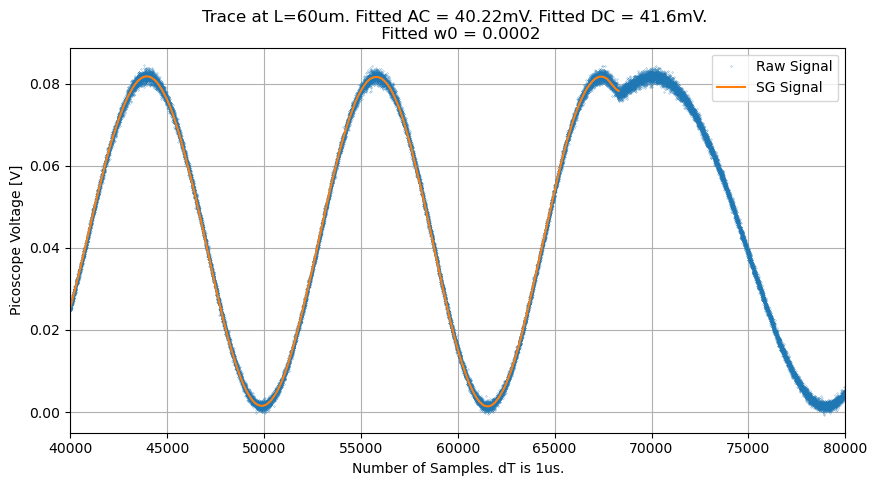

In [76]:
# Estimate non-linearity by fitting a cosine
dir_mmt = r"C:\Users\SLAB2\Documents\Waveforms\picoscope"
f_name = "19_11_24_L_1535-59.mat"
fp = os.path.join(dir_mmt, f_name)

ps_data = AnalysePSData(fp)
ps_data.get_sawtooth_local_extrema()
ps_data.filter_savgol(polyorder=2)
ps_data.split_signal_sg(buffer=0, flip=True)

sg_split = ps_data.signal_sg_split["0"]
t_sg_split = ps_data.t_split["0"]

ps_data.signal_to_analyse = np.array(sg_split)
ps_data.fit_sinusoid(6000, w0=2e-4, phase0=0, verbose=False)
acc, dcc = np.round(ps_data.p_opt["ac0"]*1e3, 2), np.round(ps_data.p_opt["dc0"]*1e3, 2)
ww = np.round(ps_data.p_opt["w0"], 6)
# print(ps_data.t0, ps_data.t1, ps_data.t0 + ps_data.N)

fig = plt.figure(figsize=(10, 5))

plt.plot(ps_data.t, ps_data.signal_raw, ".", label="Raw Signal", ms=0.4)
plt.plot(t_sg_split, sg_split, label="SG Signal")
# plt.plot(t_sg_split, ps_data.signal_cos_fit, label=f"Cosine w. const. freq")
plt.legend()
plt.grid()
plt.title("Savitky Goyal with widths size // 100")
plt.xlim(40000, 80000)
plt.ylabel("Picoscope Voltage [V]")
plt.xlabel("Number of Samples. dT is 1us.")
plt.title(f"Trace at L=60um. Fitted AC = {acc}mV. Fitted DC = {dcc}mV. \n Fitted w0 = {ww}")

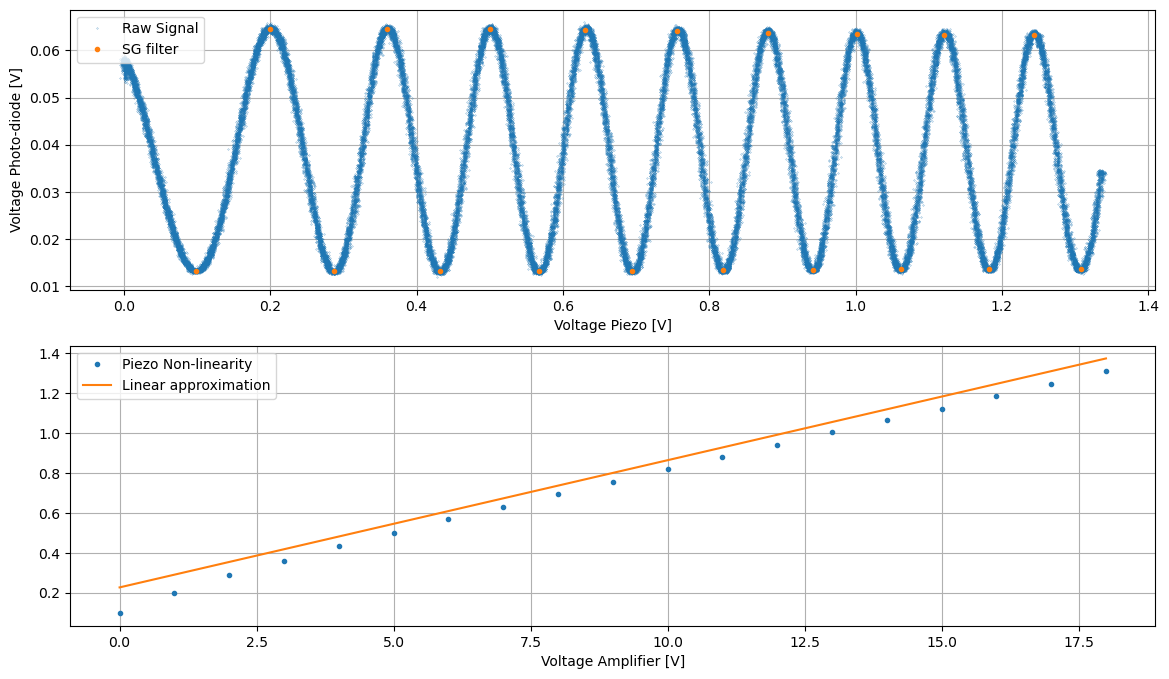

In [5]:
# Estimate non-linearity by fitting a cosine
dir_mmt = r"C:\Users\SLAB2\Documents\Waveforms\picoscope"
f_name = "121224_LUnknown_WL1534-529.mat"
fp = os.path.join(dir_mmt, f_name)

ps_data = AnalysePSData(fp)
ps_data.get_sawtooth_local_extrema()
ps_data.split_signal_sg(buffer=0, flip=True)

signal = ps_data.signal_raw_split["0"]
t_sg_split = ps_data.t_split["0"]

# Plot voltage (from amplifier) vs. 
voltage_amplifier = ps_data.signal_sawtooth_split["0"]
w_length = len(voltage_amplifier) // 30
signal_f_of_voltage = ps_data.signal_voltage_split["0"]
signal_sg = np.array(savgol_filter(signal_f_of_voltage, w_length, 2))
voltage_amplifier_ordered = np.array(ps_data.voltage_ordered["0"])

dd = signal_sg.size // 20
idx_minmax = AnalysePSData.get_idx_local_extrema(signal_sg, dd, buffer=0)

# analysis
wl_half = np.diff(voltage_amplifier_ordered[idx_minmax], axis=0)
wl_half = [voltage_amplifier_ordered[idx_minmax][0]] + wl_half.tolist()
non_linearity = np.cumsum(wl_half)
nl_range = np.arange(non_linearity.size)
lin_approx = (voltage_amplifier_ordered[idx_minmax][-1] - voltage_amplifier_ordered[idx_minmax][0]) / nl_range.size

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14, 8), sharex=False)
ax1.plot(voltage_amplifier_ordered, signal_f_of_voltage, ".", label="Raw Signal", ms=0.4)
ax1.plot(voltage_amplifier_ordered[idx_minmax], signal_sg[idx_minmax], ".", label="SG filter")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Voltage Piezo [V]")
ax1.set_ylabel("Voltage Photo-diode [V]")
# ax1.set_xlim(.4, .8)
ax2.plot(nl_range, non_linearity, ".", label="Piezo Non-linearity")
ax2.plot(nl_range, lin_approx * nl_range + voltage_amplifier_ordered[idx_minmax][0] * 2.3, label="Linear approximation")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Voltage Amplifier [V]")
ax2.set_label("Nonlinearity [a.u.]")
# ax2.set_xlim(.4, .8)

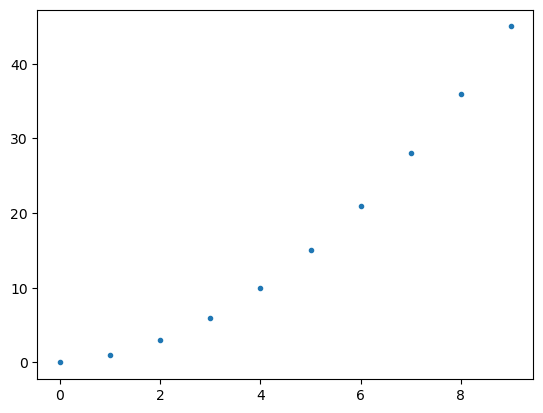

In [88]:
# Two wavelengths - visual confirmation 
plt.plot(np.arange(10), np.cumsum(np.arange(10)), ".")

Use LBD2 fringe. Edge index ix  -1
T0 and T1 for T:  1.1534165143966675 1.2841578722000122
T is  0.13074135780334473
T0 and T1 for dT:  1.2831811904907227 1.2841578722000122
dT is  0.0009766817092895508
L is  8.297647271433808


(1.0, 1.4)

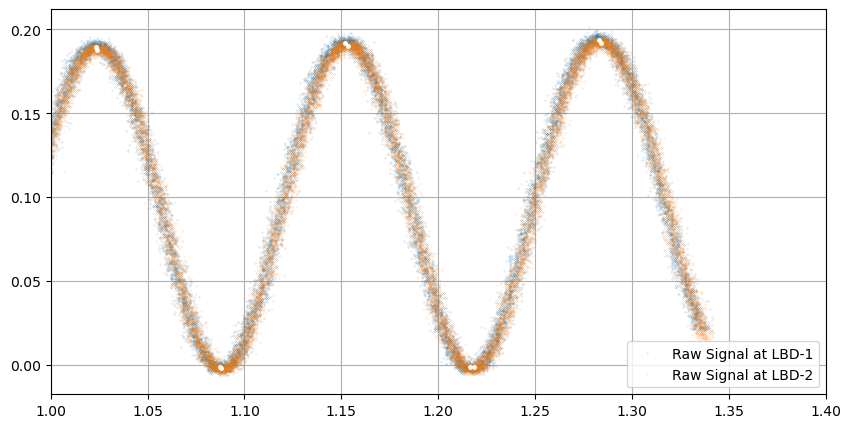

In [10]:
# Two wavelengths - visual confirmation
dir_mmt = r"C:\Users\SLAB2\Documents\Waveforms\picoscope"
f_name_lbd1 = "20250204_L80_WL1535-59.mat"
fp_lbd1 = os.path.join(dir_mmt, f_name_lbd1)
lbd1 = 1535.59e-9

ps_data_lbd1 = AnalysePSData(fp_lbd1)
ps_data_lbd1.get_sawtooth_local_extrema()
ps_data_lbd1.split_signal_sg(buffer=100, flip=True)

voltage_amplifier_lbd1 = ps_data_lbd1.signal_sawtooth_split["0"]
w_length_lbd1 = len(voltage_amplifier_lbd1) // 30
signal_f_of_voltage_lbd1 = ps_data_lbd1.signal_voltage_split["0"]
signal_sg_lbd1 = np.array(savgol_filter(signal_f_of_voltage_lbd1, w_length_lbd1, 2))
voltage_amplifier_ordered_lbd1 = np.array(ps_data_lbd1.voltage_ordered["0"])

f_name_lbd2 = "20250204_L80_WL1534-53.mat"
fp_lbd2 = os.path.join(dir_mmt, f_name_lbd2)
lbd2 = 1534.53e-9

ps_data_lbd2 = AnalysePSData(fp_lbd2)
ps_data_lbd2.get_sawtooth_local_extrema()
ps_data_lbd2.split_signal_sg(buffer=100, flip=True)

voltage_amplifier_lbd2 = ps_data_lbd2.signal_sawtooth_split["0"]
w_length_lbd2 = len(voltage_amplifier_lbd2) // 30
signal_f_of_voltage_lbd2 = ps_data_lbd2.signal_voltage_split["0"]
signal_sg_lbd2 = np.array(savgol_filter(signal_f_of_voltage_lbd2, w_length_lbd2, 2))
voltage_amplifier_ordered_lbd2 = np.array(ps_data_lbd2.voltage_ordered["0"])

data_combined = PostProcess(signal_sg_lbd1, signal_sg_lbd2, lbd1, lbd2, voltage_amplifier_ordered_lbd1, voltage_amplifier_ordered_lbd2)
data_combined.get_local_extrema(buffer=100)

fig = plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(data_combined.tdata_lbd1, signal_f_of_voltage_lbd1, ".", label="Raw Signal at LBD-1", ms=0.2)
plt.plot(data_combined.tdata_lbd2, signal_f_of_voltage_lbd2, ".", label="Raw Signal at LBD-2", ms=0.2)
plt.plot(data_combined.tdata_lbd1[data_combined.idx_lbd1], data_combined.signal_lbd1[data_combined.idx_lbd1], ".", ms=5., c="w")
plt.plot(data_combined.tdata_lbd2[data_combined.idx_lbd2], data_combined.signal_lbd2[data_combined.idx_lbd2], ".", ms=5., c="w")
plt.legend()

data_combined.calculate_T(from_left_to_right=False)
print("T is ", data_combined.T)
data_combined.calculate_dT(ilbd1=-1, ilbd2=-1)
print("dT is ", data_combined.dT)
data_combined.calculate_L()
print("L is ", data_combined.L)
plt.xlim(1, 1.4)

In [ ]:
# Two wavelengths - visual confirmation
dir_mmt = r"C:\Users\SLAB2\Documents\Waveforms\picoscope"
f_name_lbd1 = "19_11_24_L_1534-53.mat"
fp_lbd1 = os.path.join(dir_mmt, f_name_lbd1)
lbd1 = 1534.53e-9

ps_data_lbd1 = AnalysePSData(fp_lbd1)
ps_data_lbd1.get_sawtooth_local_extrema()
ps_data_lbd1.filter_savgol(polyorder=2)
ps_data_lbd1.split_signal_sg(buffer=0, flip=False)

signal_lbd1 = np.array(ps_data_lbd1.signal_sg_split["0"])
signal_lbd1_raw = np.array(ps_data_lbd1.signal_raw_split["0"])
t_lbd_1 = np.array(ps_data_lbd1.t_split["0"])

f_name_lbd2 = "19_11_24_L_1535-59.mat"
fp_lbd2 = os.path.join(dir_mmt, f_name_lbd2)
lbd2 = 1535.59e-9

ps_data_lbd2 = AnalysePSData(fp_lbd2)
ps_data_lbd2.get_sawtooth_local_extrema()
ps_data_lbd2.filter_savgol(polyorder=2)
ps_data_lbd2.split_signal_sg(buffer=0, flip=False)

signal_lbd2 = np.array(ps_data_lbd2.signal_sg_split["0"])
signal_lbd2_raw = np.array(ps_data_lbd2.signal_raw_split["0"])
t_lbd_2 = np.array(ps_data_lbd2.t_split["0"])

data_combined = PostProcess(signal_lbd1, signal_lbd2, lbd1, lbd2, t_lbd_1, t_lbd_2)
data_combined.get_local_extrema(buffer=1000)

fig = plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(data_combined.tdata_lbd1, signal_lbd1_raw, ".", label="Raw Signal at LBD-1", ms=0.2)
plt.plot(data_combined.tdata_lbd2, signal_lbd2_raw, ".", label="Raw Signal at LBD-2", ms=0.2)
# plt.plot(data_combined.tdata_lbd1, data_combined.signal_lbd1, ".-", label="Signal at LBD-1", ms=0.02)
# plt.plot(data_combined.tdata_lbd2, data_combined.signal_lbd2, ".-", label="Signal at LBD-2", ms=0.02)
plt.plot(data_combined.tdata_lbd1[data_combined.idx_lbd1], data_combined.signal_lbd1[data_combined.idx_lbd1], ".", ms=5., c="w")
plt.plot(data_combined.tdata_lbd2[data_combined.idx_lbd2], data_combined.signal_lbd2[data_combined.idx_lbd2], ".", ms=5., c="w")
plt.legend()

data_combined.calculate_T(from_left_to_right=False)
print("T is ", data_combined.T)
data_combined.calculate_dT(ilbd1=-1, ilbd2=-1)
print("dT is ", data_combined.dT)
data_combined.calculate_L()
print("L is ", data_combined.L)
plt.xlim(50_000, 70_000)